##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using TensorFlow to run Monte Carlo Simulations on Black Scholes

_Notebook orignially contributed by: Evan Hennis_

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/tree/master/community/en/MonteCarloBlackScholes.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/tree/master/community/en/MonteCarloBlackScholes.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview  

This notebook is an update to my previous notebook about using verion 1 of TensorFlow to run Monte Carlo Simulations. You can find that notebook in my repo [https://github.com/ehennis/Blog/blob/master/BlackScholes/MonteCarloBlackScholes.ipynb](https://github.com/ehennis/Blog/blob/master/BlackScholes/MonteCarloBlackScholes.ipynb) if you want the ins and outs. Be sure to read the heading where I reference Matthias Groncki who did the heavy lifting. In this notebook, I am going to convert the code to using TensorFlow v2.

## TensorFlow 2.0  
This is a "port" of TensorFlow 2.0. There is an [update utility](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/tools/compatibility) on the TensorFlow GitHub repository that will try and update your code. It isn't perfect but it does a good job of finding the libraries that have moved.  

The ones it found in my code were 'tf.placeholder', 'tf.log', 'tf.session', and 'tf.cumprod'. The script just moved those to the 'tf.compat.v1' library. For me, I didn't want to use the compatible version if possible. 

**Functions, not sessions**  
The biggest change, by far, was not using *session.run* and converting all of the code to using functions. Along with this comes not using placeholders and using variables.

**Variable, not placeholders**  
With using variables and not the placeholders I had to think about the code as python versus the existing TensorFlow code. I need to create the variables OUTSIDE the method and the *assign* them within the method. If I didn't, the garbage collection would clear them out and cause issues.

**TensorFlow Probability**  
I was using *tf.contrib.distributions.Normal* and it was recommended that I start using the tensorflow_probability instead. The web site for more information is [https://www.tensorflow.org/probability/](https://www.tensorflow.org/probability/). My issue is that not everything has been ported over yet so I will have to wait until everything has been released.

**Stock Market/Black Scholes**  
As a refresher, and to keep you from having to flip back and forth from this notebook to my previous notebook, here are some quick hits.  
* Call Options: These are contracts that state that you will buy a stock at a certain price at a certain date and you will pay the option premium  
* Black Scholes: A nobel prize winning financial formula that helps predict what the *correct* price of the option premium should be. The formula is: $$C(S,t) = S_tN(d_1) - Ke^{-r(T-t)}N(d_2)$$ This would then expand to:
$$d_1 = \frac{ln(\frac{s}{K}) + (r + \frac{\sigma^2}{2}) (T-t)}{\sigma \sqrt{T-t}}$$  
$$d_2 = d_1 - \sigma \sqrt{T-t} = \frac{ln(\frac{s}{K}) + (r - \frac{\sigma^2}{2}) (T-t)}{\sigma \sqrt{T-t}}$$  

## Setup

In [ ]:
!pip install tf-nightly-2.0-preview

In [1]:
from __future__ import absolute_import, division, print_function

#Notebook Imports
import tensorflow as tf
#import tensorflow_probability as tfp 
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
print( tf.__version__)

1.13.0-dev20190110


**Python Black Scholes**  
Here is how you would use python to calculate Black Scholes. With the change to v2 the TensorFlow version looks very similar.

In [3]:
def blackscholes(stockPrice, strike, time_to_expr, imp_vol, risk_free):
    #S: Stock Price
    #K: Strike Price
    #T: Time to Maturity
    #Sigma: Volatility of underlying asset
    #r: Interest Rate
    
    S = stockPrice
    K = strike
    T = time_to_expr
    sigma = imp_vol
    r = risk_free
    
    d_1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d_2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return (S * stats.norm.cdf(d_1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d_2,0.0,1.0))

In [4]:
blackscholes(50.,55.,0.25,0.2,0.02)

0.5219699197228529

**Results**  
The today price that is returned is 0.52. That means that if the option is "perfectly" priced it would cost you \$0.52.

**TensorFlow Time!**  
Now, we will do the same thing using TensorFlow. Note that we will return the price. I have removed the "greek" values from my old notebook because I didn't want to mess with them and I wanted to make this as straight forward as possible.  

## [TFv2 Changes]
`tf.placeholder` no longer exists so I need to create `tf.Variable`. I also need to create these OUTSIDE the method because python will garbage collect them.  

`tf.log` -> `tf.math.log`.

`tf.cumprod` -> `tf.math.cumprod`

`tf.contrib.distributions.Normal` -> `tf.compat.v1.distributions.Normal`. This will eventually come from `TensorFlow Probability` but that library hasn't been built for v2 yet.  

`Session` -> `Function`. This is obviously the largest change. With the addition of eager execution we no longer use the sessions.  

`bs_tf = blackscholes` -> `tf.function(blackscholes_tf2)`. As stated above, I need to add tf.function to my method call.  

Here is a good link from the TF GitHub page: [https://github.com/tensorflow/docs/blob/7c9d49ee188c67a315deaf92ebd41fd0f3b15c4a/site/en/r2/guide/effective_tf2.md](https://github.com/tensorflow/docs/blob/7c9d49ee188c67a315deaf92ebd41fd0f3b15c4a/site/en/r2/guide/effective_tf2.md)

In [5]:
#Formula Variables
stock_price = 50.
strike_price = 55.
time_to_expire = 0.25
implied_volitility = 0.2
risk_free_rate_of_return = 0.02
seed = 187

In [6]:
def blackscholes_tf2(stockPrice, strike, time_to_expr, imp_vol, risk_free, show_greeks = True):
    d_1 = (tf.math.log(stockPrice / strike) + (risk_free + 0.5 * imp_vol ** 2) * time_to_expr) / (imp_vol * tf.sqrt(time_to_expr))
    d_2 = (tf.math.log(stockPrice / strike) + (risk_free - 0.5 * imp_vol ** 2) * time_to_expr) / (imp_vol * tf.sqrt(time_to_expr))
    npv = stockPrice * tf.compat.v1.distributions.Normal(0.,1.).cdf(d_1) - strike * tf.exp(-risk_free * time_to_expr) * tf.compat.v1.distributions.Normal(0.,1.).cdf(d_2)
    target_calc = npv
    return target_calc

In [7]:
bs_tf = tf.function(blackscholes_tf2)
bs_tf(stock_price,strike_price,time_to_expire,implied_volitility,risk_free_rate_of_return).numpy()

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


0.5219698

**Note**  
You will get a warning about `tensorflow.python.ops.distributions.normal` being deprecated. As stated above the probability package wasn't available when this was created so I needed to keep the `tf.compat.v1.distributions` class. Once that is available we can update this method.

**Results**  
As you can see we again get \$0.52. This matches what the python function returned. You will also see that there were some warnings. These will be fixed when I can use the TensorFlow Probability library.

**Monte Carlo Time!!**  

In [8]:
def black_scholes_formula(stockPrice, strike, time_to_expr, imp_vol, risk_free, timedelta, stdnorm_random_variates):
    return stockPrice * tf.math.cumprod(tf.exp((risk_free - 0.5 * imp_vol ** 2) * timedelta + imp_vol * tf.sqrt(timedelta) * stdnorm_random_variates), axis = 1)

In [9]:
def make_path_simulator(stockPrice, strike, time_to_expr, imp_vol, risk_free, seed, n_sims, obs):
    #Create the time variables
    if seed != 0:
        np.random.seed(seed)
    stdnorm_random_variates = np.random.randn(n_sims, obs)
    timedelta = time_to_expr / stdnorm_random_variates.shape[1]
    return black_scholes_formula(stockPrice, strike, time_to_expr, imp_vol, risk_free, timedelta, stdnorm_random_variates)

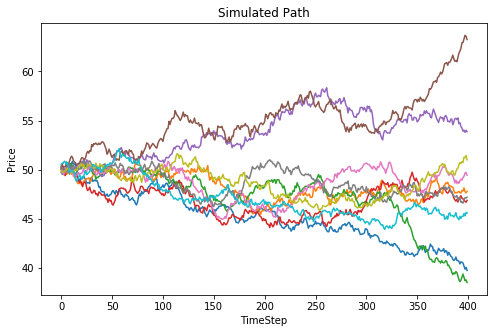

In [10]:
path_simulator = tf.function(make_path_simulator)
paths = path_simulator(stock_price,strike_price,time_to_expire,implied_volitility,risk_free_rate_of_return, seed, 10, 400) #Seed 1312, #Sims 10, #Obs: 400
plt.figure(figsize=(8,5))
_ = plt.plot(np.transpose(paths))
_ = plt.title('Simulated Path')
_ = plt.ylabel('Price')
_ = plt.xlabel('TimeStep')
plt.show()

In [11]:
#Check if the expected value of the simulation is close to the expected mean
path_simulator = tf.function(make_path_simulator)
paths = path_simulator(stock_price,strike_price,time_to_expire,implied_volitility,risk_free_rate_of_return, seed, 10000000, 2)
assert np.mean(paths[:, 1])-np.exp(0.03*2)*100<0.01,'Value is too large'

**Pricing the option**  
Now, we are going to price the option by extending the previous function

In [12]:
def create_plain_vanilla_mc_tf_pricer(stockPrice, strike, time_to_expr, imp_vol, risk_free, seed, n_sims, obs):
    if seed != 0:
        np.random.seed(seed)
    stdnorm_random_variates = np.random.randn(n_sims, 1)
    timedelta = time_to_expr / stdnorm_random_variates.shape[1]
    S_T = black_scholes_formula(stockPrice, strike, time_to_expr, imp_vol, risk_free, timedelta, stdnorm_random_variates)
    payout = tf.maximum(S_T[:,-1] - strike, 0)
    npv = tf.exp(-risk_free*time_to_expr) * tf.reduce_mean(payout)
    target_calc = npv
    return target_calc

In [13]:
sims = 1000000
observations = 1

plain_vanilla_mc_tf_pricer = tf.function(create_plain_vanilla_mc_tf_pricer)
plain_vanilla_mc_tf_pricer(stock_price,strike_price,time_to_expire,implied_volitility,risk_free_rate_of_return, seed, sims,observations).numpy()

0.52246726

**Conclusion**  
We have verified that our TensorFlow implementation gets the same solution as the python implementation. I have also shown how to convert the *session.run* to using *functions*. Many thanks to Matthias for inspiring me to dig into TensorFlow using Monte Carlo Simulations. Thanks to Paige Bailey [@DynamicWebPaige](https://twitter.com/DynamicWebPaige) and Martin Wicke [@martin_wicke](https://twitter.com/martin_wicke)

**Author**  
Evan Hennis  
Twitter: @TheNurl  
Blog: https://eckronsoftware.wordpress.com  
GitHub: https://github.com/ehennis